# Introduction

This notebook demonstrates the workflow for detecting collective signalling events in microscopy images and accompanies the tutorial published in [Methods in Microscopy](https://www.degruyter.com/journal/key/mim/html?lang=en#overview).

The biological phenomenon studied here are apoptosis-induced collective ERK activity signalling waves in starved, wild type MCF10A epithelium, published earlier in the journal [Developmental Cell](https://doi.org/10.1016/j.devcel.2021.05.007). The key computational components of the workflow are:

- [StarDist](https://stardist.net) for image segmentation,
- [scikit-image](https://scikit-image.org) for image manipulation,
- [btrack](https://btrack.readthedocs.io/en/latest/) for object tracking,
- ARCOS, an algorithm for Automatic Recognition of COllective Signalling, described extensively in the [Journal of Cell Biology](https://doi.org/10.1083/jcb.202207048) and [available online](https://arcos.gitbook.io/home/) as R and Python packages, as well as a plugin for [napari](https://napari.org/stable/) image viewer.

![Workflow overview](extras/napari-flow.png)

## Imports

In [1]:
# folder operations
import os

# Segmentation
# call before pandas, otherwise hangs before "Loading network weights from 'weights_best.h5'." (bug?)
from stardist.models import StarDist2D
from csbdeep.utils import normalize

# Basic data manipulation
import numpy as np
import pandas as pd

# TIFF stacks I/O
from tifffile import imread, imwrite

# Parallel processing
from joblib import Parallel, delayed

# napari image viewer
import napari


# Segmented label manipulation
from skimage.segmentation import expand_labels
from skimage.morphology import remove_small_objects
from skimage.measure import regionprops_table
from skimage.util import map_array, montage

# Tracking
import btrack
from btrack.constants import BayesianUpdates

# ARCOS
from arcos4py import ARCOS
from arcos4py.tools import filterCollev, calculate_statistics, estimate_eps
from arcos4py.plotting import NoodlePlot, plotOriginalDetrended
from arcos4py import validation

# Plotting
from matplotlib import pyplot as plt

# from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull

import plotnine as p9
from mizani.formatters import percent_format

## Custom functions

In [2]:
# Calculate properties in a labelled region
def loc_calc_regionprops(frame, labels, frameid):
    loc_res = pd.DataFrame(
        regionprops_table(
            labels, frame, properties=["intensity_mean", "centroid", "label"]
        )
    )
    loc_res["frame"] = frameid
    return loc_res

## Constants

In [3]:
# Save fonts instead of paths in SVG figures
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = "Arial"

DIR_OUT_DATA = "output-data"
DIR_OUT_PLOT = "output-plots"


IMG_NAPARI = True  # Whether to show images in napari
IMG_NB = True  # Whether to show images in the notebook
DATA_SAVE = True  # Whether to save intermediate data
PLOT_SAVE = True # Whether to save plots
PARCOMP = True  # Whether to perform computations in parallel

if PARCOMP:
    # Parallel processing
    from joblib import Parallel, delayed

    # Number of parallel jobs; set to -1 to use all available cores
    NJOBS = -1


# Analyze only part of the stack (here, chosen frames 35-55)
STACK_TRIM = False

# 20-colour tableau palette without greys: #7f7f7f and #c7c7c7
TAB20 = [
    "#1f77b4",
    "#aec7e8",
    "#ff7f0e",
    "#ffbb78",
    "#2ca02c",
    "#98df8a",
    "#d62728",
    "#ff9896",
    "#9467bd",
    "#c5b0d5",
    "#8c564b",
    "#c49c94",
    "#e377c2",
    "#f7b6d2",
    "#bcbd22",
    "#dbdb8d",
    "#17becf",
    "#9edae5",
]

# Minimum nuclei size in pixel (for filtering out small nuclei)
MIN_NUC_SIZE = 200

# Column names in single-cell timeseries from segmentation
COL_POS: list = ["x", "y"]
COL_FRAME: str = "t"
COL_RT: str = "rt"
COL_OBJ_ID: str = "obj_id"
COL_TRK_ID: str = "track_id"
COL_MEAS: str = "cnr"

# column name with collective event track ids
COL_COLL_ID: str = "cl_id"

# Tracking
## Path to btrack config file
BT_CONFIG_FILE: str = "extras/cell_config.json"

## Tracking radius [px]
EPS_TRACK: int = 70

## Minimum track length [frames] (for filtering and passing on to ARCOS)
if STACK_TRIM:
    TRK_MIN_LEN: int = 10
else:
    TRK_MIN_LEN: int = 60

# Time-series pre-processing
## Values for measurement clipping and interpolation
ACQ_FREQ: int = 5
INTERPOLATE: bool = False
CLIP: bool = False
CLIP_LOW: float = 0.001
CLIP_HIGH: float = 0.999

## Binarization parameters
DETRENDING_METHOD: str = "runmed"  # can be "none", "runmed" or "lm"
SMOOTHK: int = 3
BIASK: int = 25  # needed only if BINARIZATION_METHOD method = runmed
PEAK_THRESHOLD: float = 0.1  # needed only if BINARIZATION_METHOD method = runmed
DEGREE_OF_POLYNOMIAL: int = 1  # needed only if BINARIZATION_METHOD method = lm
BINARIZATION_THRESHOLD: float = 0.4

## Collective event detection
EPS_COLL: float = 100
MIN_CLUSTER_SIZE: int = 3
NPREV_FRAMES: int = 1

## Filtering of collective events
MIN_COLLECTIVE_EVENT_DURATION: int = 2
MIN_TOTAL_EVENT_SIZE: int = 3

## Validation of CE detection
N_VALID_STEPS = 200

# crops of a FOV for plotting a single frame
PXSZ = 332.80 / 1024  # pixel size in um

if STACK_TRIM:
    n_frame_show = 12 # selected frame number to show
else:
    n_frame_show = 47


fov_crop_y = slice(384, 896)  # [px]
fov_crop_x = slice(128, 640)  # [px]

In [4]:
# Create directories for outputting plots and data

if not os.path.exists(DIR_OUT_DATA):
    os.makedirs(DIR_OUT_DATA)
    print(f"Directory {DIR_OUT_DATA} created successfully!")
else:
    print(f"Directory {DIR_OUT_DATA} already exists!")

if not os.path.exists(DIR_OUT_PLOT):
    os.makedirs(DIR_OUT_PLOT)
    print(f"Directory {DIR_OUT_PLOT} created successfully!")
else:
    print(f"Directory {DIR_OUT_PLOT} already exists!")

Directory output-data created successfully!
Directory output-plots created successfully!


In [5]:
# Loading image stacks with nuclear and ERK channels
np_nuc = imread("../data/c1-nuc.tif")
np_erk = imread("../data/c3-erk.tif")

In [6]:
# Trim the stack
if STACK_TRIM:
    np_nuc = np_nuc[35:55]
    np_erk = np_erk[35:55]

## napari visualisation

Showing the results of every step in the interactive image viewer, [napari](https://napari.org/stable/).

In [7]:
# Open napari viewer
if IMG_NAPARI:
    if napari.current_viewer() is None:
        viewer = napari.Viewer()

In [10]:
# Add raw image stacks to napari
if IMG_NAPARI:
    viewer.add_image(np_nuc, colormap="gray", contrast_limits=[750, 3500])
    viewer.add_image(np_erk, colormap="gray", contrast_limits=[1000, 6400])

## Selected frames

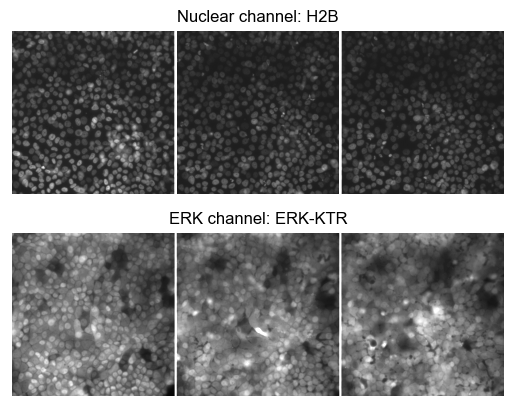

In [10]:
# Show a montage of 3 time points from the nuclear and ERK channels
if IMG_NB:
    fig, axarr = plt.subplots(2, 1)

    np_nuc_sel = np_nuc[np.linspace(0, len(np_nuc) - 1, 3).astype(np.int32)]
    np_erk_sel = np_erk[np.linspace(0, len(np_erk) - 1, 3).astype(np.int32)]

    imMontNuc = montage(
        np_nuc_sel,
        padding_width=10,
        fill=np.max(np_nuc),
        grid_shape=(1, np_nuc_sel.shape[0]),
    )

    imMontErk = montage(
        np_erk_sel,
        padding_width=10,
        fill=np.max(np_erk),
        grid_shape=(1, np_erk_sel.shape[0]),
    )

    # fig.axis('off')
    axarr[0].set_axis_off()
    axarr[0].set_title("Nuclear channel: H2B")
    axarr[0].imshow(imMontNuc, cmap="gray", vmin=50, vmax=8000)

    axarr[1].set_axis_off()
    axarr[1].set_title("ERK channel: ERK-KTR")
    axarr[1].imshow(imMontErk, cmap="gray", vmin=500, vmax=7000)

    plt.show()

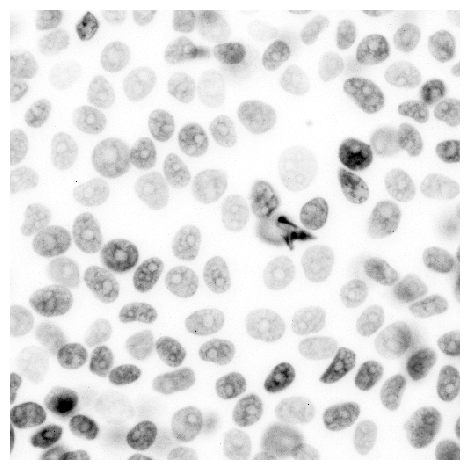

In [14]:
np_nuc_show = np_nuc[n_frame_show, fov_crop_y, fov_crop_x]

# Show the image
plt.imshow(np_nuc_show, cmap="Greys", interpolation="none", vmin=1000, vmax=5000)
plt.axis("off")
plt.tight_layout()

if PLOT_SAVE:
    plt.savefig(
        f"{DIR_OUT_PLOT}/fig2-raw-nuc.png", bbox_inches="tight", pad_inches=0.0, dpi=300
    )
plt.show()

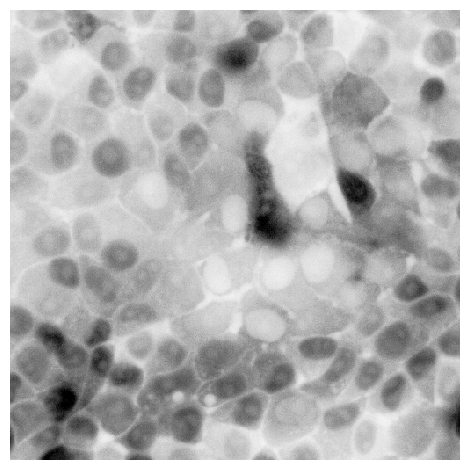

In [19]:
np_erk_show = np_erk[n_frame_show, fov_crop_y, fov_crop_x]

# Show the image
plt.imshow(np_erk_show, cmap="Greys", interpolation="none", vmin=1500, vmax=7000)
plt.axis("off")
plt.tight_layout()

if PLOT_SAVE:
    plt.savefig(
        f"{DIR_OUT_PLOT}/fig2-raw-erk.png", bbox_inches="tight", pad_inches=0.0, dpi=300
    )
plt.show()

# Segmentation

Using a pre-trained [StarDist](https://stardist.net) model `2D_versatile_fluo` for nuclear segmentation.

In [8]:
# Image stack parameters
n_frames = np_nuc.shape[0]
axis_norm = (0, 1)

In [9]:
# Create a pretrained model
model = StarDist2D.from_pretrained("2D_versatile_fluo")

# Pre-allocate np array for nuclear labels
np_lab = np.zeros_like(np_nuc)

# Loop over frames, normalize and segment
# Warning: longer execution! Takes approx. 2'30" with GPU support (M2 Max)
for idx_frame in range(n_frames):
    np_frame = np.asarray(np_nuc[idx_frame])
    np_frame = normalize(np_frame, 1.0, 99.8, axis=axis_norm)
    #    labels, details = model.predict_instances(np_frame, prob_thresh=0.5, nms_thresh=0.3)
    labels, details = model.predict_instances(np_frame)
    np_lab[idx_frame] = labels

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [11]:
# Filter out small nuclei
# Pre-allocate np array for labels
np_lab_filt = np.zeros_like(np_lab)

for idx_frame in range(n_frames):
    np_lab_filt[idx_frame] = remove_small_objects(
        np_lab[idx_frame],
        min_size=MIN_NUC_SIZE,
    )

In [ ]:
if DATA_SAVE:
    np.savez_compressed(file=f"{DIR_OUT_DATA}/np_lab_large.npz", arr=np_lab_filt)

In [ ]:
# If saved before, load labelled nuclear mask from the file
# np_lab_large = np.load(f"{DIR_OUT_DATA}/np_lab_large.npz", )['arr']

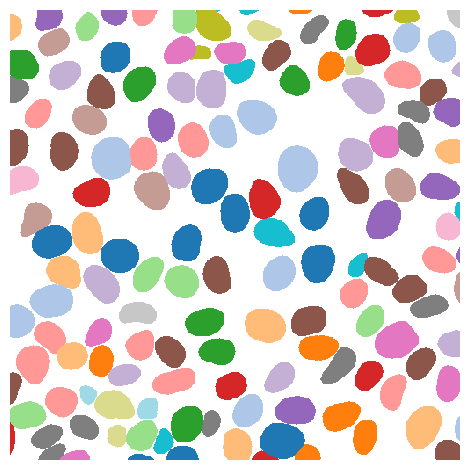

In [12]:
# Convert zeros to nan's, so the background is displayed in white
np_lab_show = np.where(
    np_lab_filt[n_frame_show, fov_crop_y, fov_crop_x] == 0,
    np.nan,
    np_lab_filt[n_frame_show, fov_crop_y, fov_crop_x],
)


# Show the image
plt.imshow(np_lab_show, cmap="tab20", interpolation="none")
plt.axis("off")
plt.tight_layout()

if PLOT_SAVE:
    plt.savefig(
        f"{DIR_OUT_PLOT}/fig2-seg-nuc.png", bbox_inches="tight", pad_inches=0.0, dpi=300
    )
plt.show()

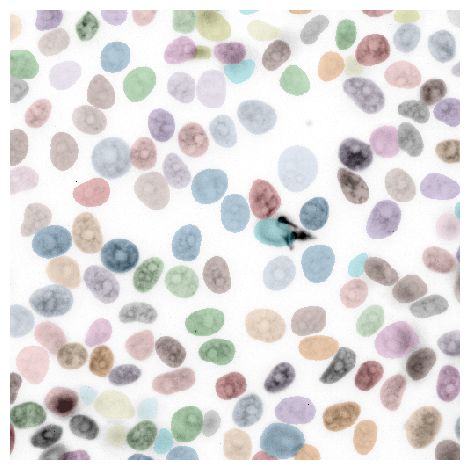

In [15]:
# Overlay nuclear masks on EKR-KTR
plt.imshow(np_nuc_show, cmap="Greys", interpolation="none", vmin=1000, vmax=5000)
plt.imshow(np_lab_show, cmap="tab20", alpha=0.25, interpolation="none")
plt.axis("off")
plt.tight_layout()

if PLOT_SAVE:
    plt.savefig(
        f"{DIR_OUT_PLOT}/fig3-raw-nuc-seg.png", bbox_inches="tight", pad_inches=0.0, dpi=300
    )
plt.show()

## Cytosolic ring

### Method 1

Create a mask by expanding nuclear labels by 6 pixels, then subtract a smaller mask obtained from expanding nuclear labels by 2 pixels. The result is a 4-pixel wide cytosolic ring separated by 2 pixels from the nucleus.

In [16]:
if PARCOMP:
    # Process labels in parallel
    def process_frame(idx_frame):
        return expand_labels(np_lab_filt[idx_frame], 6) - expand_labels(np_lab_filt[idx_frame], 2) 

    np_lab_ring = np.array(
        Parallel(n_jobs=NJOBS)(delayed(process_frame)(idx_frame) for idx_frame in range(n_frames))
    )
else:
    # Process labels sequentially by frame
    np_lab_ring = np.zeros_like(np_lab)

    # Loop over frames to filter out small nuclei
    for idx_frame in range(n_frames):
        np_lab_ring[idx_frame] = expand_labels(np_lab_filt[idx_frame], 6) - expand_labels(np_lab_filt[idx_frame], 2)

### Method 2

Create label mask for the cytoplasmic ring:

- nuclear mask expanded by 4 pixels,
- reduce expanded labels to the edge using `reduce_labels_to_label_edges` from the `pyclesperanto_prototype` module
- expand the edge by 2 pixels to create a ring

This method is also used in the napari GUI workflow.

In [ ]:
# from pyclesperanto_prototype import reduce_labels_to_label_edges

# if PARCOMP:
#     # Process labels in parallel
#     def process_frame(idx_frame):
#         np_lab_exp = expand_labels(np_lab_large[idx_frame], 4)
#         np_lab_edge = np.asarray(reduce_labels_to_label_edges(np_lab_exp))
#         return expand_labels(np_lab_edge, 2)

#     np_lab_ring = np.array(
#         Parallel(n_jobs=NJOBS)(delayed(process_frame)(idx_frame) for idx_frame in range(n_frames))
#     )
# else:
#     # Process labels sequentially by frame
#     np_lab_ring = np.zeros_like(np_lab)

#     # Loop over frames to filter out small nuclei
#     for idx_frame in range(n_frames):
#         np_lab_exp = expand_labels(np_lab_large[idx_frame], 4)
#         np_lab_edge = np.asarray(reduce_labels_to_label_edges(np_lab_exp))
#         np_lab_ring[idx_frame] = expand_labels(np_lab_edge, 2)

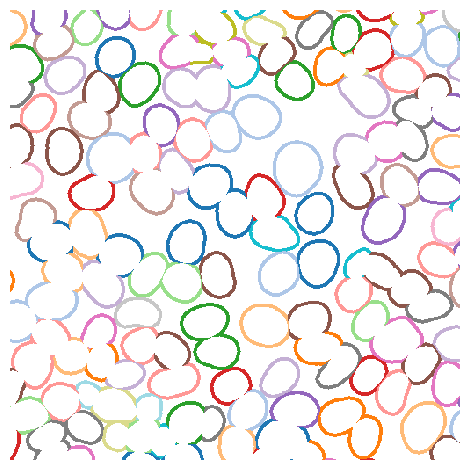

In [17]:
# Convert zeros to nan's, so the background is displayed in white
np_lab_ring_show = np.where(
    np_lab_ring[n_frame_show, fov_crop_y, fov_crop_x] == 0,
    np.nan,
    np_lab_ring[n_frame_show, fov_crop_y, fov_crop_x],
)

# Show the image
plt.imshow(np_lab_ring_show, cmap="tab20", interpolation="none")
plt.axis("off")
plt.tight_layout()

if PLOT_SAVE:
    plt.savefig(
        f"{DIR_OUT_PLOT}/fig2-seg-ring.png", bbox_inches="tight", pad_inches=0.0, dpi=300
    )
plt.show()

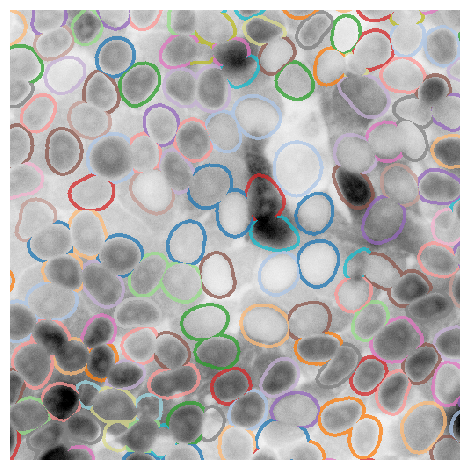

In [20]:
# Overlay cytoplasmic rings on EKR-KTR
plt.imshow(np_erk_show, cmap="Greys", interpolation="none", vmin=1500, vmax=7000)
plt.imshow(np_lab_ring_show, cmap="tab20", alpha=0.75, interpolation="none")
plt.axis("off")
plt.tight_layout()

if PLOT_SAVE:
    plt.savefig(
        f"{DIR_OUT_PLOT}/fig3-raw-erk-ring.png",
        bbox_inches="tight",
        pad_inches=0.0,
        dpi=300,
    )
plt.show()

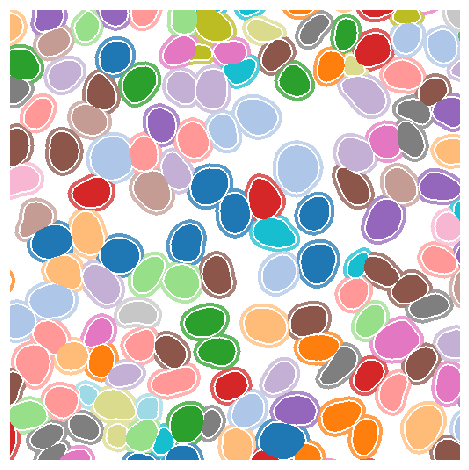

In [21]:
# Both labels
plt.imshow(np_lab_show, cmap="tab20", interpolation="none")
plt.imshow(np_lab_ring_show, cmap="tab20", alpha=0.75, interpolation="none")
plt.axis("off")
plt.tight_layout()

if PLOT_SAVE:
    plt.savefig(
        f"{DIR_OUT_PLOT}/fig3-seg-nuc-ring.png",
        bbox_inches="tight",
        pad_inches=0.0,
        dpi=300,
    )
plt.show()

In [22]:
# Add labels to napari
if IMG_NAPARI:
    viewer.add_labels(np_lab_filt)
    viewer.add_labels(np_lab_ring)

# Measurement

Extracting fluorescent intensities from labeled masks using `regionprops_table` from `skimage.measure`.

The resulting `df_prop` table contains x & y positions of nuclear centroids and mean fluorescent intensities from nuclear and cytoplasmic ring masks, `intensity_mean_nuc` and `intensity_mean_cyto`, respectively. The table will be merged with the result of tracking.

In [23]:
# Extract measurements from images based on nuclear and ring masks.
# Extracted: intensity_mean, centroid, label
PARCOMP = False
if PARCOMP:
    # Calculate properties in parallel
    df_prop_nuc = pd.concat(
        Parallel(n_jobs=NJOBS)(
            delayed(loc_calc_regionprops)(img, lab, fid)
            for (fid, (img, lab)) in enumerate(zip(np_erk, np_lab_filt))
        )
    )
    df_prop_cyto = pd.concat(
        Parallel(n_jobs=NJOBS)(
            delayed(loc_calc_regionprops)(img, lab, fid)
            for (fid, (img, lab)) in enumerate(zip(np_erk, np_lab_ring))
        )
    )

else:
    # Calculate properties sequentially by frame
    df_prop_nuc = pd.DataFrame()
    df_prop_cyto = pd.DataFrame()

    for idx_frame in range(n_frames):
        df_prop_nuc_frame = pd.DataFrame(
            regionprops_table(
                np_lab_filt[idx_frame],
                np_erk[idx_frame],
                properties=["intensity_mean", "centroid", "label"],
            )
        )

        df_tmp_prop_cyto = pd.DataFrame(
            regionprops_table(
                np_lab_ring[idx_frame], np_erk[idx_frame], properties=["intensity_mean", "label"]
            )
        )
        df_prop_nuc_frame["frame"] = idx_frame
        df_tmp_prop_cyto["frame"] = idx_frame

        df_prop_nuc = pd.concat([df_prop_nuc, df_prop_nuc_frame])
        df_prop_cyto = pd.concat([df_prop_cyto, df_tmp_prop_cyto])

In [25]:
# Rename columns names and merge into a single df with properties
df_prop_nuc.rename(
    columns={
        "frame": COL_FRAME,
        "label": COL_OBJ_ID,
        "intensity_mean": "intensity_mean_nuc",
        "centroid-0": COL_POS[1],
        "centroid-1": COL_POS[0],
    },
    inplace=True,
)

df_prop_cyto.rename(
    columns={
        "frame": COL_FRAME,
        "label": COL_OBJ_ID,
        "intensity_mean": "intensity_mean_cyto",
        "centroid-0": COL_POS[1],
        "centroid-1": COL_POS[0],
    },
    inplace=True,
)

# Check whether columns exist before dropping
if df_prop_cyto.columns.isin(COL_POS).any():
    df_prop_cyto.drop(columns=COL_POS, inplace=True)

#df_prop = df_prop_nuc.merge(df_prop_cyto, how="inner", on=[COL_FRAME, COL_OBJ_ID])
df_prop = pd.merge(df_prop_nuc, 
                   df_prop_cyto, 
                   how="inner", 
                   on=[COL_FRAME, COL_OBJ_ID])

df_prop.head()

,intensity_mean_nuc,y,x,obj_id,t,intensity_mean_cyto
0,5136.505569,637.352723,419.853342,1,0,3908.886869
1,4741.591051,685.993757,192.289282,2,0,3529.716621
2,3301.129191,558.544563,891.987735,3,0,2945.008287
3,4421.078056,869.618557,678.393225,4,0,3050.199377
4,3949.989940,399.014085,222.124748,5,0,3136.732106


# Tracking

Particle tracking with the [Bayesian Tracker (btrack)](https://btrack.readthedocs.io/en/latest/index.html).

A detailed guide to configuration parameters in the JSON file can be found [here](https://btrack.readthedocs.io/en/latest/user_guide/configuration.html).

The tracker uses the particle tracking model stored in a JSON file with the path defined in `BT_CONFIG_FILE`.

In [26]:
# Create btrack objects (with properties) from the segmentation data
# By setting properties=('area',) the tracking algorithm takes into account the mask's area in addition to x/y.
# By setting assign_class_ID=True adds the object ID that will be used later in merging tracking results with the df_prop table.
obj_bt = btrack.utils.segmentation_to_objects(
    np_lab_filt, properties=("area",), assign_class_ID=True
)

[INFO][2025/05/08 02:39:40 PM] Localizing objects from segmentation...
INFO:btrack.io._localization:Localizing objects from segmentation...
[INFO][2025/05/08 02:39:56 PM] Objects are of type: <class 'dict'>
INFO:btrack.io.utils:Objects are of type: <class 'dict'>
[INFO][2025/05/08 02:39:57 PM] ...Found 170355 objects in 300 frames.
INFO:btrack.io._localization:...Found 170355 objects in 300 frames.


In [27]:
# Initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:
    # configure the tracker using a config JSON file
    tracker.configure(BT_CONFIG_FILE)

    tracker.update_method = BayesianUpdates.APPROXIMATE
    tracker.max_search_radius = EPS_TRACK

    # append the objects to be tracked
    tracker.append(obj_bt)

    # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
    tracker.volume = ((0, np_nuc.shape[2]), (0, np_nuc.shape[1]))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    # get the tracks as a python list
    ls_tracks = tracker.tracks

    # optional: get the data in a format for napari
    bt_data, bt_props, bt_graph = tracker.to_napari()

[INFO][2025/05/08 02:40:03 PM] Loaded btrack: /Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/btrack/libs/libtracker.dylib
INFO:btrack.libwrapper:Loaded btrack: /Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/btrack/libs/libtracker.dylib
[INFO][2025/05/08 02:40:03 PM] Starting BayesianTracker session
INFO:btrack.core:Starting BayesianTracker session
[INFO][2025/05/08 02:40:03 PM] Loading configuration file: extras/cell_config.json
INFO:btrack.config:Loading configuration file: extras/cell_config.json
[INFO][2025/05/08 02:40:03 PM] Objects are of type: <class 'list'>
INFO:btrack.io.utils:Objects are of type: <class 'list'>
[WARNING][2025/05/08 02:40:03 PM] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2025/05/08 02:40:03 PM] Starting tracking... 
INFO:btrack.core:Starting tracking... 
[INFO][2025/05/08 02:40:03 PM] Update using: ['MOTION']
INFO:btrack.core:Update using: ['MOTION']
[INFO][2025/05/08 02:40:03 PM] 

GLPK Integer Optimizer 5.0
12620 rows, 13163 columns, 21354 non-zeros
13163 integer variables, all of which are binary
Preprocessing...
6310 rows, 13163 columns, 21354 non-zeros
13163 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6310
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6310 rows, 13163 columns, 21354 non-zeros
*     0: obj =   2.705285898e+04 inf =   0.000e+00 (5414)
Perturbing LP to avoid stalling [712]...
Removing LP perturbation [4346]...
*  4346: obj =   9.544763257e+03 inf =   0.000e+00 (0) 7
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4346: mip =     not found yet >=              -inf        (1; 0)
+  4380: >>>>>   9.550750720e+03 >=   9.547466798e+03 < 0.1% (12; 0)
+  4406: >>>>>   9.550513965e+03 >=   9.548248497e+03 < 0.1% (18; 2)
+  4444: >>

[INFO][2025/05/08 02:40:08 PM] Completed optimization with 2115 tracks
INFO:btrack.core:Completed optimization with 2115 tracks
[INFO][2025/05/08 02:40:08 PM] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session


Combine the result of tracking with the measurement table `df_prop` to obtain a final table with single-cell data in long format with the cytoplasmic/nuclear ERK ratio, `cnr` and track identifiers, `track_id`.

In [28]:
# Convert btrack output to pandas
df_tracks_bt = pd.concat(
    pd.DataFrame(t.to_dict(["ID", "t", "x", "y"])) for t in ls_tracks
)

# Rename columns to make them consistent with the rest
df_tracks_bt.rename(
    columns={
        "ID": COL_TRK_ID,
        "t": COL_FRAME,
        "x": COL_POS[0],
        "y": COL_POS[1],
        "class_id": COL_OBJ_ID,
    },
    inplace=True,
)

# Set column types
df_tracks_bt[COL_OBJ_ID] = df_tracks_bt[COL_OBJ_ID].astype(
    "Int32"
)  # Int32/64 allows integer nan's https://stackoverflow.com/a/65580754/1898713

# Merge btrack output with the initial single-cell data from segmentation
df_tracks = pd.merge(
    df_prop[
        [
            COL_FRAME,
            COL_OBJ_ID,
            COL_POS[0],
            COL_POS[1],
            "intensity_mean_nuc",
            "intensity_mean_cyto",
        ]
    ],
    df_tracks_bt[[COL_FRAME, COL_OBJ_ID, COL_TRK_ID]].dropna(),
    on=[COL_FRAME, COL_OBJ_ID],
    how="left",
)

# Calculate cyto/nuc ratio
df_tracks[COL_MEAS] = df_tracks["intensity_mean_cyto"] / df_tracks["intensity_mean_nuc"]

# Add a column with real time in hours
df_tracks[COL_RT] = df_tracks[COL_FRAME] * ACQ_FREQ / 60

# final df with track id's
df_tracks.head()

,t,obj_id,x,y,intensity_mean_nuc,intensity_mean_cyto,track_id,cnr,rt
0,0,1,419.853342,637.352723,5136.505569,3908.886869,362,0.761001,0.0
1,0,2,192.289282,685.993757,4741.591051,3529.716621,391,0.744416,0.0
2,0,3,891.987735,558.544563,3301.129191,2945.008287,331,0.892121,0.0
3,0,4,678.393225,869.618557,4421.078056,3050.199377,501,0.689922,0.0
4,0,5,222.124748,399.014085,3949.989940,3136.732106,237,0.794111,0.0


## Tracking visualisations

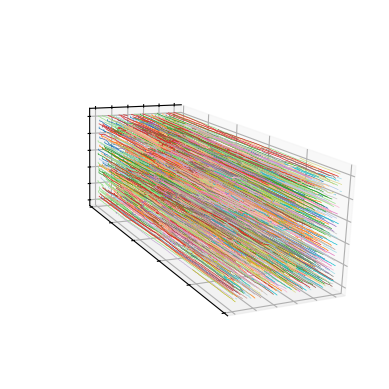

In [29]:
# 3D projection of all identified tracks
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.view_init(120, 150, 61.5)
ax.set_proj_type("persp", focal_length=0.4)
ax.set_box_aspect(aspect=(1, 1, 3))
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# Create a list of unique track_ids
v_track_ids = df_tracks[COL_TRK_ID].unique()

# Create a color map for the unique track_ids
v_colors = plt.cm.tab20(np.linspace(0, 1, len(v_track_ids)))

for track_idx, track_id in enumerate(v_track_ids):
    df_track = df_tracks[df_tracks[COL_TRK_ID] == track_id]
    ax.plot(
        df_track[COL_POS[0]],
        df_track[COL_POS[1]],
        df_track[COL_RT],
        color=v_colors[track_idx],
        linewidth=0.5,
    )

if PLOT_SAVE:
    plt.savefig(
        f"{DIR_OUT_PLOT}/fig2-tracks3D.png", bbox_inches="tight", pad_inches=0.0, dpi=300
    )
plt.show()

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3 x 2 in image.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: output-plots/fig5-tracks-proj-y.pdf


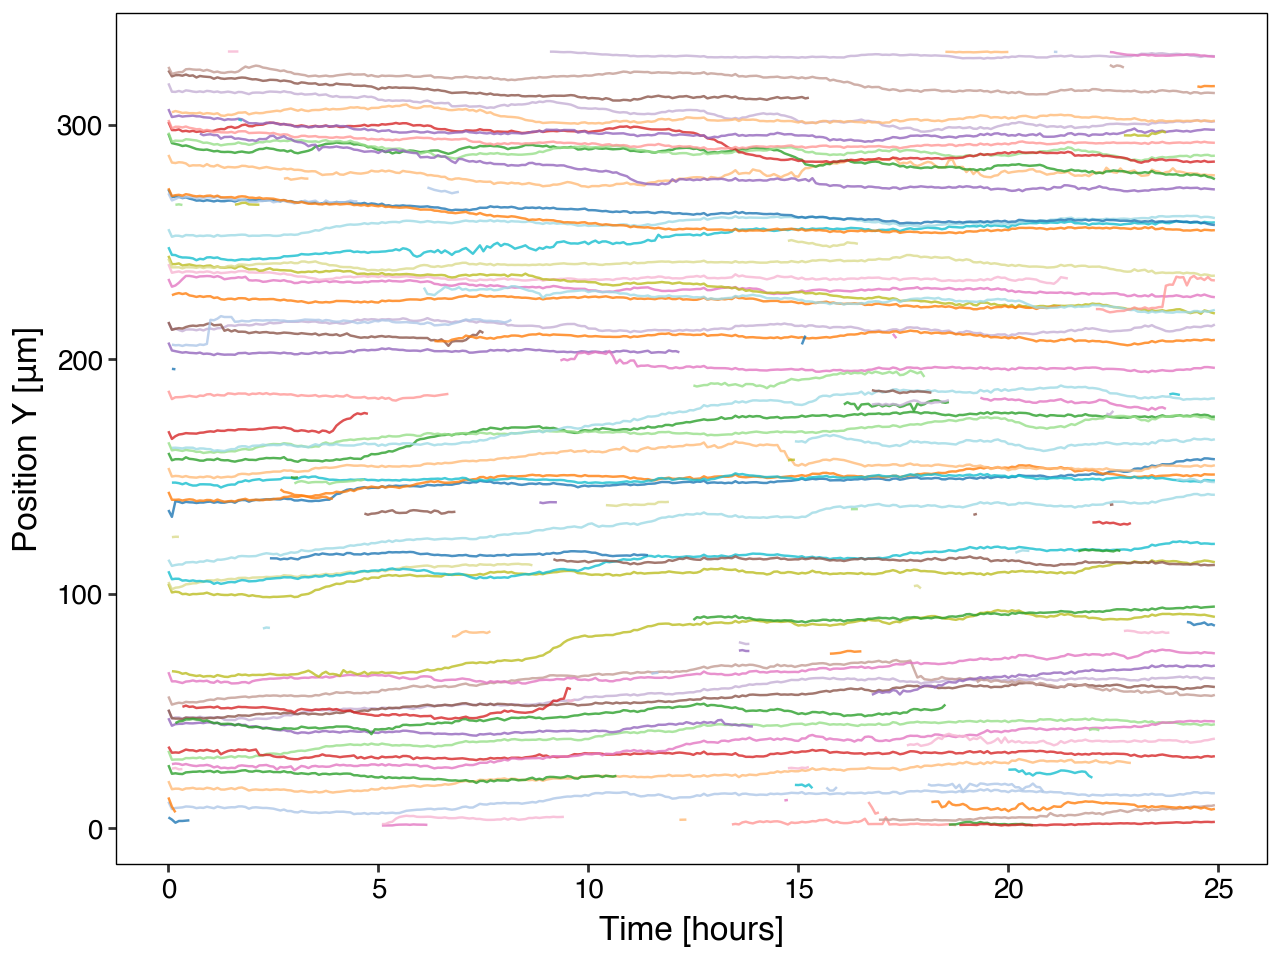

In [30]:
# Random sample of 200 tracks
np.random.seed(3)
v_track_ids_rnd = np.random.choice(df_tracks["track_id"].unique(), 200)

s_tmp_x = f"{COL_FRAME} * {ACQ_FREQ} / 60"
s_tmp_y = f"{COL_POS[1]} * {PXSZ}"

p_tracks_proj = (
    p9.ggplot(
        df_tracks[df_tracks[COL_TRK_ID].isin(v_track_ids_rnd)],
        p9.aes(x=s_tmp_x, y=s_tmp_y, group=COL_TRK_ID),
    )
    + p9.geom_line(p9.aes(color="pd.Categorical(track_id)"), size=0.5, alpha=0.8)
    + p9.scale_color_manual(
        values=np.take(np.array(TAB20), range(0, len(v_track_ids_rnd)), mode="wrap")
    )
    + p9.xlab("Time [hours]")
    + p9.ylab("Position Y [μm]")
    + p9.theme_bw()
    + p9.theme(
        legend_position="none",
        panel_grid=p9.element_blank(),
        panel_border=p9.element_rect(size=0.5, colour="black"),
        panel_background=p9.element_blank(),
        text=p9.element_text(family="Helvetica"),
        axis_text_x=p9.element_text(colour="black", size=10),
        axis_text_y=p9.element_text(colour="black", size=10),
        axis_title_x=p9.element_text(colour="black", size=12),
        axis_title_y=p9.element_text(colour="black", size=12),
    )
)

if PLOT_SAVE:
    p9.ggsave(p_tracks_proj, 
              f"{DIR_OUT_PLOT}/fig5-tracks-proj-y.pdf", 
              width=3, 
              height=2)

p_tracks_proj

## Track lengths

The histogram of track lengths obtained from `btrack`. The vertical dashed line indicates the threshold of minimal track lengths kept in the further analysis.

In [31]:
df_tracks_len = (
    df_tracks.groupby("track_id")["t"]
    .apply(lambda x: x.max() - x.min() + 1)
    .reset_index(name="track_len")
)
df_tracks_len["track_len"] = df_tracks_len["track_len"] * ACQ_FREQ / 60

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 2 in image.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: output-plots/fig5-tracks-hist-len.pdf


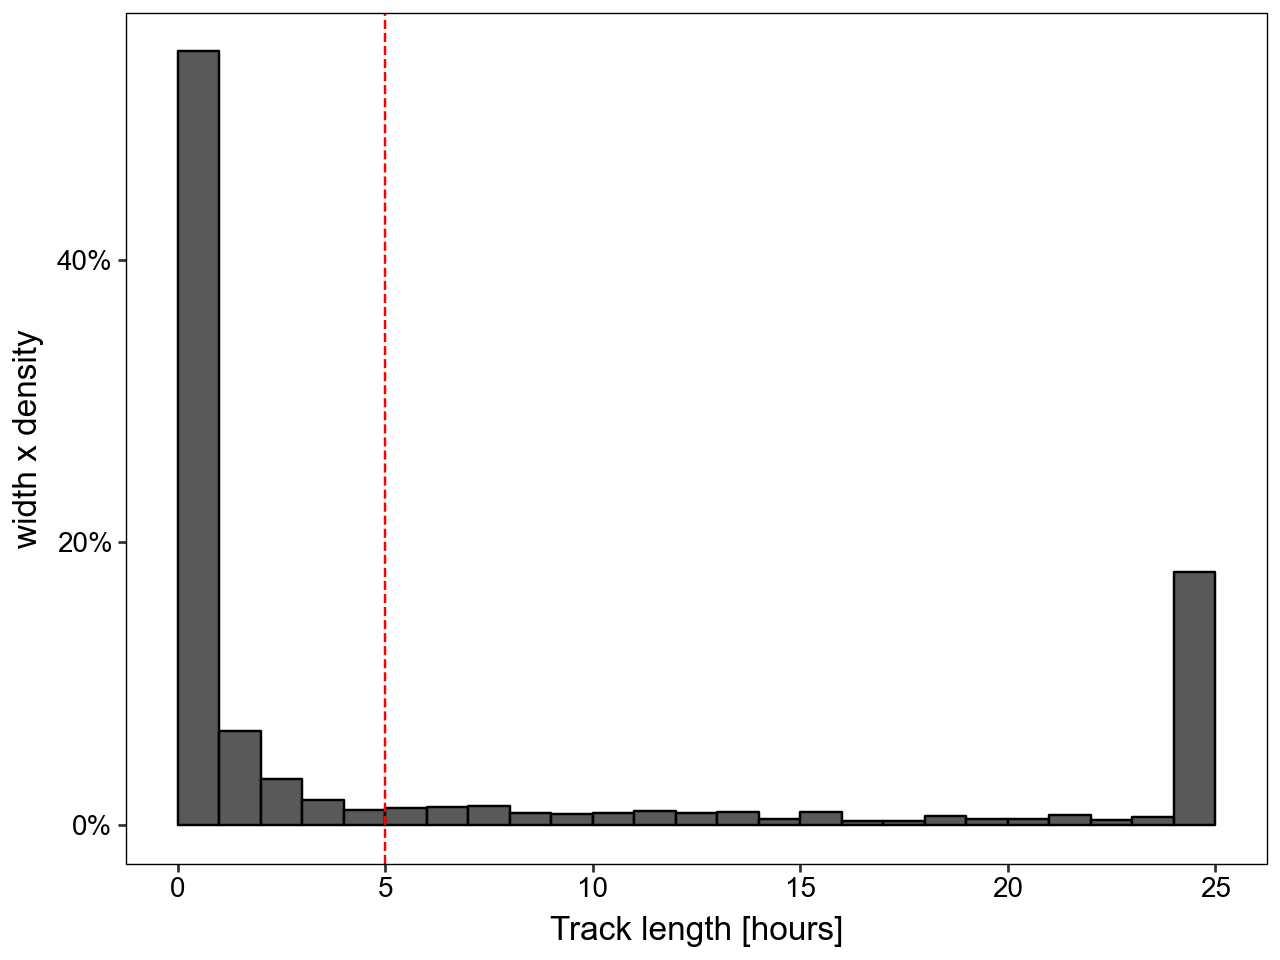

In [32]:
p_tracks_len_hist = (
    p9.ggplot(df_tracks_len, p9.aes(x="track_len", y=p9.after_stat("width*density")))
    + p9.geom_histogram(binwidth=1, boundary=0, color="black")
    + p9.geom_vline(
        xintercept=TRK_MIN_LEN * ACQ_FREQ / 60, color="red", linetype="dashed"
    )
    + p9.scale_y_continuous(labels=percent_format())
    + p9.xlab("Track length [hours]")
    + p9.ylab("width x density")
    + p9.theme_bw()
    + p9.theme(
        legend_position="none",
        panel_grid=p9.element_blank(),
        panel_border=p9.element_rect(size=0.5, colour="black"),
        panel_background=p9.element_blank(),
        text=p9.element_text(family="Arial"),
        axis_text_x=p9.element_text(colour="black", size=10),
        axis_text_y=p9.element_text(colour="black", size=10),
        axis_title_x=p9.element_text(colour="black", size=12),
        axis_title_y=p9.element_text(colour="black", size=12),
    )
)

if PLOT_SAVE:
    p9.ggsave(
        p_tracks_len_hist, 
        f"{DIR_OUT_PLOT}/fig5-tracks-hist-len.pdf", 
        width=2.5, 
        height=2
    )

p_tracks_len_hist

## Remapping labels

In [33]:
# Re-map object IDs to track IDs in labeled images

# Pre-allocate arrays
# Labels re-mapped according to track IDs
np_lab_large_remap = np.zeros_like(np_lab_filt)
np_lab_ring_remap = np.zeros_like(np_lab_ring)

# Labels with the measurement: the cytoplaasmic/nuclear retio
np_lab_large_meas = np.zeros_like(
    np_lab_filt, dtype="float64"
)  # the float dtype is needed to store CNR
np_lab_ring_meas = np.zeros_like(
    np_lab_filt, dtype="float64"
)  # the float dtype is needed to store CNR

# Re-map
for idx_frame in range(n_frames):
    np_frame = df_tracks[df_tracks[COL_FRAME] == idx_frame][
        [COL_OBJ_ID, COL_TRK_ID, COL_MEAS]
    ].to_numpy()
    np_nuc_frame = np_lab_filt[idx_frame]
    np_ring_frame = np_lab_ring[idx_frame]
    np_lab_large_remap[idx_frame] = map_array(np_nuc_frame, np_frame[:, 0], np_frame[:, 1])
    np_lab_ring_remap[idx_frame] = map_array(np_ring_frame, np_frame[:, 0], np_frame[:, 1])
    np_lab_large_meas[idx_frame] = map_array(np_nuc_frame, np_frame[:, 0], np_frame[:, 2])
    np_lab_ring_meas[idx_frame] = map_array(np_ring_frame, np_frame[:, 0], np_frame[:, 2])

In [39]:
# Add re-mapped layers to napari
if IMG_NAPARI:
    viewer.add_labels(np_lab_large_remap)
    viewer.add_labels(np_lab_ring_remap)
    viewer.add_image(
        np_lab_large_meas,
        contrast_limits=[0.6, 1.3],
        colormap="inferno",
    )
    viewer.add_image(
        np_lab_ring_meas,
        contrast_limits=[0.6, 1.3],
        colormap="inferno",
    )

    viewer.layers["np_lab_filt"].visible = False
    viewer.layers["np_lab_ring"].visible = False

    # Track data from the tracker
    viewer.add_tracks(
        bt_data,
        properties=bt_props,
        graph=bt_graph,
        blending="translucent",
        visible=True,
    )

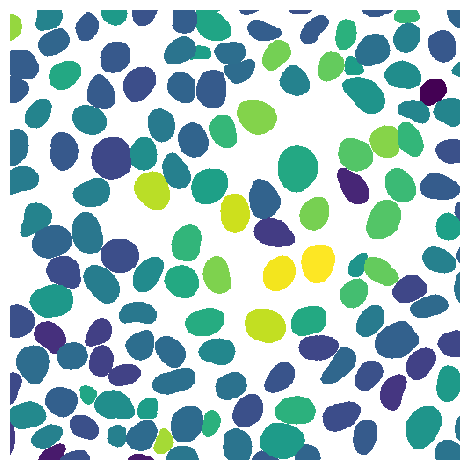

In [40]:
# Convert zeros to nan's, so the background is displayed in white
np_lab_show = np.where(
    np_lab_large_meas[n_frame_show, fov_crop_y, fov_crop_x] == 0,
    np.nan,
    np_lab_large_meas[n_frame_show, fov_crop_y, fov_crop_x],
)

# Show the image
plt.imshow(np_lab_show, cmap="viridis", interpolation="none")
plt.axis("off")
plt.tight_layout()

if PLOT_SAVE:
    plt.savefig(
        f"{DIR_OUT_PLOT}/fig2-seg-nuc-erk.png", bbox_inches="tight", pad_inches=0.0, dpi=300
    )
plt.show()

In [ ]:
if DATA_SAVE:
    df_tracks.to_csv(f"{DIR_OUT_DATA}/df_tracks.csv.gz", compression="gzip", index=False)

# Collective events

Detection of collective events (CEs) using [ARCOS](https://arcos.gitbook.io/home/).

## Data preparation

In [39]:
# Read single-cell time series if saved before
# df_tracks = pd.read_csv(f"{DIR_OUT_DATA}/df_tracks.csv.gz", compression='gzip')

In [41]:
# Filter out short tracks (shorter than 5 hours)
df_tracks_long = df_tracks[
    df_tracks.groupby(COL_TRK_ID)[COL_TRK_ID].transform("size") >= TRK_MIN_LEN
]

# Create an ARCOS object
obj_arcos = ARCOS(
    data=df_tracks_long,
    position_columns=COL_POS,
    frame_column=COL_FRAME,
    obj_id_column=COL_TRK_ID,
    measurement_column=COL_MEAS,
    clid_column=COL_COLL_ID,
)

# Interpolate and clip time-series data if necessary
if INTERPOLATE:
    obj_arcos.interpolate_measurements()  # interpolation of missing values, optional
if CLIP:
    obj_arcos.clip_meas(CLIP_LOW, CLIP_HIGH)  # clipping of measurement value, optional

Sample ERK activity time series:

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3 x 2 in image.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: output-plots/fig5-tracks-erk.pdf


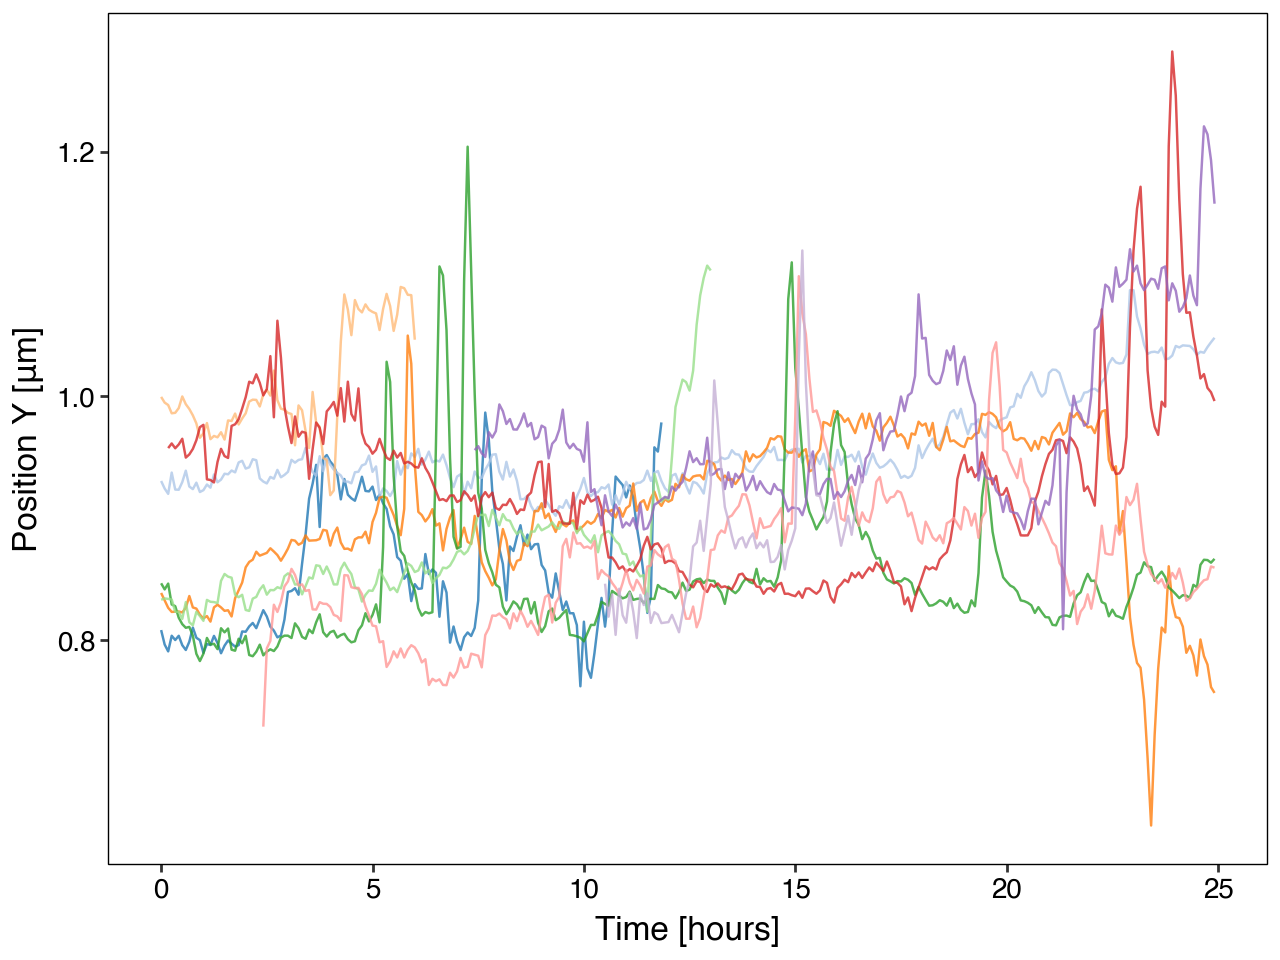

In [42]:
np.random.seed(7)
v_track_ids_rnd = np.random.choice(df_tracks_long["track_id"].unique(), 10)

s_tmp_x = f"{COL_FRAME} * {ACQ_FREQ} / 60"
s_tmp_y = f"{COL_MEAS}"

p_tracks_erk = (
    p9.ggplot(
        df_tracks_long[df_tracks_long[COL_TRK_ID].isin(v_track_ids_rnd)],
        p9.aes(x=s_tmp_x, y=s_tmp_y, group=COL_TRK_ID),
    )
    + p9.geom_line(p9.aes(color="pd.Categorical(track_id)"), size=0.5, alpha=0.8)
    + p9.scale_color_manual(
        values=np.take(np.array(TAB20), range(0, len(v_track_ids_rnd)), mode="wrap")
    )
    + p9.xlab("Time [hours]")
    + p9.ylab("Position Y [μm]")
    + p9.theme_bw()
    + p9.theme(
        legend_position="none",
        panel_grid=p9.element_blank(),
        panel_border=p9.element_rect(size=0.5, colour="black"),
        panel_background=p9.element_blank(),
        text=p9.element_text(family="Helvetica"),
        axis_text_x=p9.element_text(colour="black", size=10),
        axis_text_y=p9.element_text(colour="black", size=10),
        axis_title_x=p9.element_text(colour="black", size=12),
        axis_title_y=p9.element_text(colour="black", size=12),
    )
)

if PLOT_SAVE:
    p9.ggsave(p_tracks_erk, f"{DIR_OUT_PLOT}/fig5-tracks-erk.pdf", width=3, height=2)

p_tracks_erk

## Time series detrending and binarisation

Detrending and binarisation add a new column with the measurement rescaled between 0 and 1, and a column with a binarised measurement. 

In [43]:
# Detrend and binarize data
obj_arcos.bin_measurements(
    smooth_k=SMOOTHK,
    bias_k=BIASK,
    peak_threshold=PEAK_THRESHOLD,
    binarization_threshold=BINARIZATION_THRESHOLD,
    bias_method=DETRENDING_METHOD,
)  # detrending and binarization

obj_arcos.data.head()

,t,obj_id,x,y,intensity_mean_nuc,intensity_mean_cyto,track_id,cnr,rt,cnr.resc,cnr.bin
573,0,578,6.847185,11.493298,3628.394102,2286.750000,1,0.630237,0.000000,0.0,0
908,1,312,15.984749,19.132898,2265.015251,2129.062893,1,0.939977,0.083333,1.0,1
1461,2,269,16.641026,20.386752,2289.929487,2157.852071,1,0.942322,0.166667,0.0,0
2016,3,223,16.293737,20.717063,2287.477322,2115.275660,1,0.924720,0.250000,0.0,0
2621,4,232,16.306695,20.414687,2298.367171,2090.761905,1,0.909673,0.333333,0.0,0


/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.


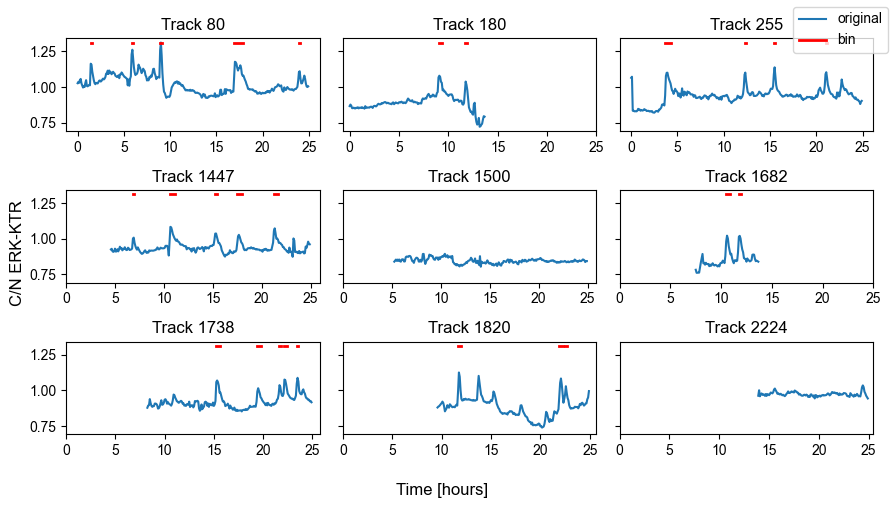

In [44]:
p_detrended = plotOriginalDetrended(
    obj_arcos.data,
    frame_column = COL_FRAME,
    measurement_column = COL_MEAS,
    detrended_column = "cnr.resc",
    obj_id_column = COL_TRK_ID,
    seed=13,
)

# plotDetrended.plot_original_and_detrended(n_samples=25, subplots=(5, 5), plotsize=(20, 10), add_binary_segments = True)
fig, ax = p_detrended.plot_original(
    n_samples=9, subplots=(3, 3), plotsize=(9, 5), add_binary_segments=True
)

# Custom labels for x-axis ticks
labels = np.arange(0, 360, step=60) * ACQ_FREQ / 60
labels = labels.astype(int)

for a in ax.flatten():
    a.set_xticks(np.arange(0, 360, step=60))
    a.set_xticklabels(labels, family="Arial")

fig.supxlabel("Time [hours]")
fig.supylabel("C/N ERK-KTR")

if PLOT_SAVE:
    fig.savefig(f"{DIR_OUT_PLOT}/fig6-tracks-bin.svg", bbox_inches="tight", pad_inches=0.0)

## Detection of CEs

The search radius `EPS_COLL` for spatial clustering is the critical parameter for ARCOS. If `ESP_COLL` is too large, then independent CEs are merged into a single cluster; if too small, then a single CE might be split into smaller events. Here, we calculate the mean nearest neighbor distance from all nuclei across the entire time-lapse. This allows us to estimate the `EPS_COLL`, which we set to approximately twice that distance to 100 pixels.

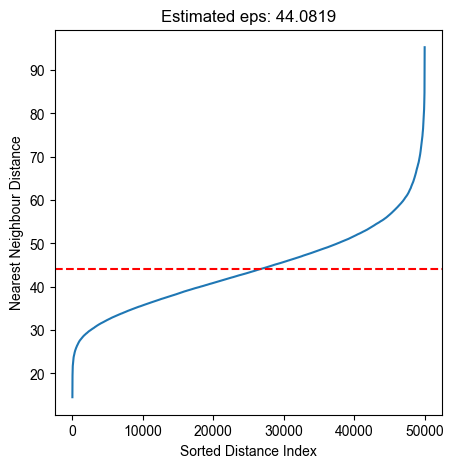

In [45]:
p_nn = estimate_eps(
    obj_arcos.data,
    method="mean",
    position_columns = COL_POS,
    frame_column=COL_FRAME,
    n_neighbors=5,
    plot=True,
    plt_size=(5, 5),
    max_samples=50000,
    mean_multiplier=1
)

Detection of collective events adds a new column with cluster identifiers.

In [46]:
# Detect and track collective events
df_ce = obj_arcos.track_collective_events(
    eps=EPS_COLL, min_clustersize=MIN_CLUSTER_SIZE, n_prev=NPREV_FRAMES
)

# Filter collective events
filterer = filterCollev(
    data=df_ce,
    frame_column=COL_FRAME,
    clid_column=COL_COLL_ID,
    obj_id_column=COL_OBJ_ID,
)  # initialize class

df_ce_filt = filterer.filter(
    min_duration=MIN_COLLECTIVE_EVENT_DURATION, min_total_size=MIN_TOTAL_EVENT_SIZE
)  #

if DATA_SAVE:
    df_ce_filt.to_csv(
        f"{DIR_OUT_DATA}/df_ce_filt.csv.gz", compression="gzip", index=False
    )

df_ce_filt.head()

100%|██████████| 300/300 [00:00<00:00, 503.61it/s]


,t,obj_id,x,y,intensity_mean_nuc,intensity_mean_cyto,track_id,cnr,rt,cnr.resc,cnr.bin,cl_id
0,17,9,878.819788,107.061837,2489.283569,2897.696319,80,1.164068,1.416667,0.662595,1,1
1,17,216,923.176772,108.820666,2612.927412,2675.958449,82,1.024123,1.416667,0.469070,1,1
2,17,70,964.533804,146.542886,2814.160444,2648.826797,109,0.941249,1.416667,0.969451,1,1
3,17,106,843.104816,153.366856,2795.703966,2999.273224,115,1.072815,1.416667,1.000000,1,1
4,17,463,897.036464,172.774586,2950.975691,3106.615385,122,1.052742,1.416667,0.566547,1,1


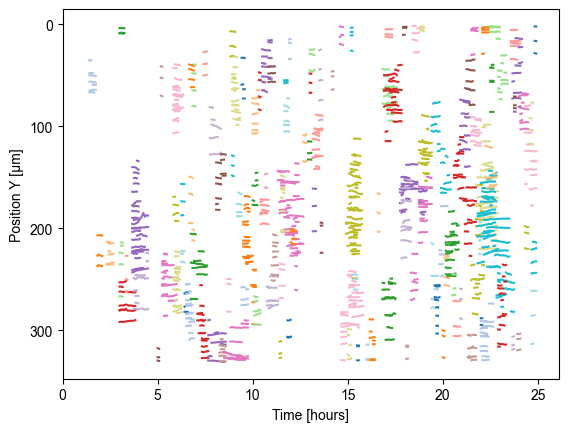

In [47]:
# Noodle plot
fig, ax = NoodlePlot(
    df_ce_filt, COL_COLL_ID, COL_TRK_ID, COL_FRAME, COL_POS[0], COL_POS[1]
).plot("y", color_cylce=TAB20)

# Custom labels for x-axis ticks
v_lab_x = np.arange(0, 360, step=60) * ACQ_FREQ / 60
v_lab_x = v_lab_x.astype(int)

ax.set_xticks(np.arange(0, 360, step=60))
ax.set_xticklabels(v_lab_x, family="Arial")

# Custom labels for y-axis ticks
v_lab_y = np.arange(0, 1024, step=100 / PXSZ) * PXSZ
v_lab_y = v_lab_y.astype(int)

ax.set_yticks(np.arange(0, 1024, step=100 / PXSZ))
ax.set_yticklabels(v_lab_y, family="Arial")

ax.invert_yaxis()

plt.xlabel("Time [hours]")
plt.ylabel("Position Y [μm]")

if PLOT_SAVE:
    fig.savefig(f"{DIR_OUT_PLOT}/fig6-noodle.svg", bbox_inches="tight", pad_inches=0.0)

## Statistics of CEs

In [48]:
# Calculate statistics of filtered CEs
df_ce_stats = calculate_statistics(
    data=df_ce_filt,
    frame_column=COL_FRAME,
    clid_column=COL_COLL_ID,
    obj_id_column=COL_TRK_ID,
)

median_duration_CE = df_ce_stats["duration"].median()
median_total_size_CE = df_ce_stats["total_size"].median()

mean_duration_CE = df_ce_stats["duration"].mean()
mean_total_size_CE = df_ce_stats["total_size"].mean()

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3 in image.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: output-plots/fig6-ce-dur-sz.pdf


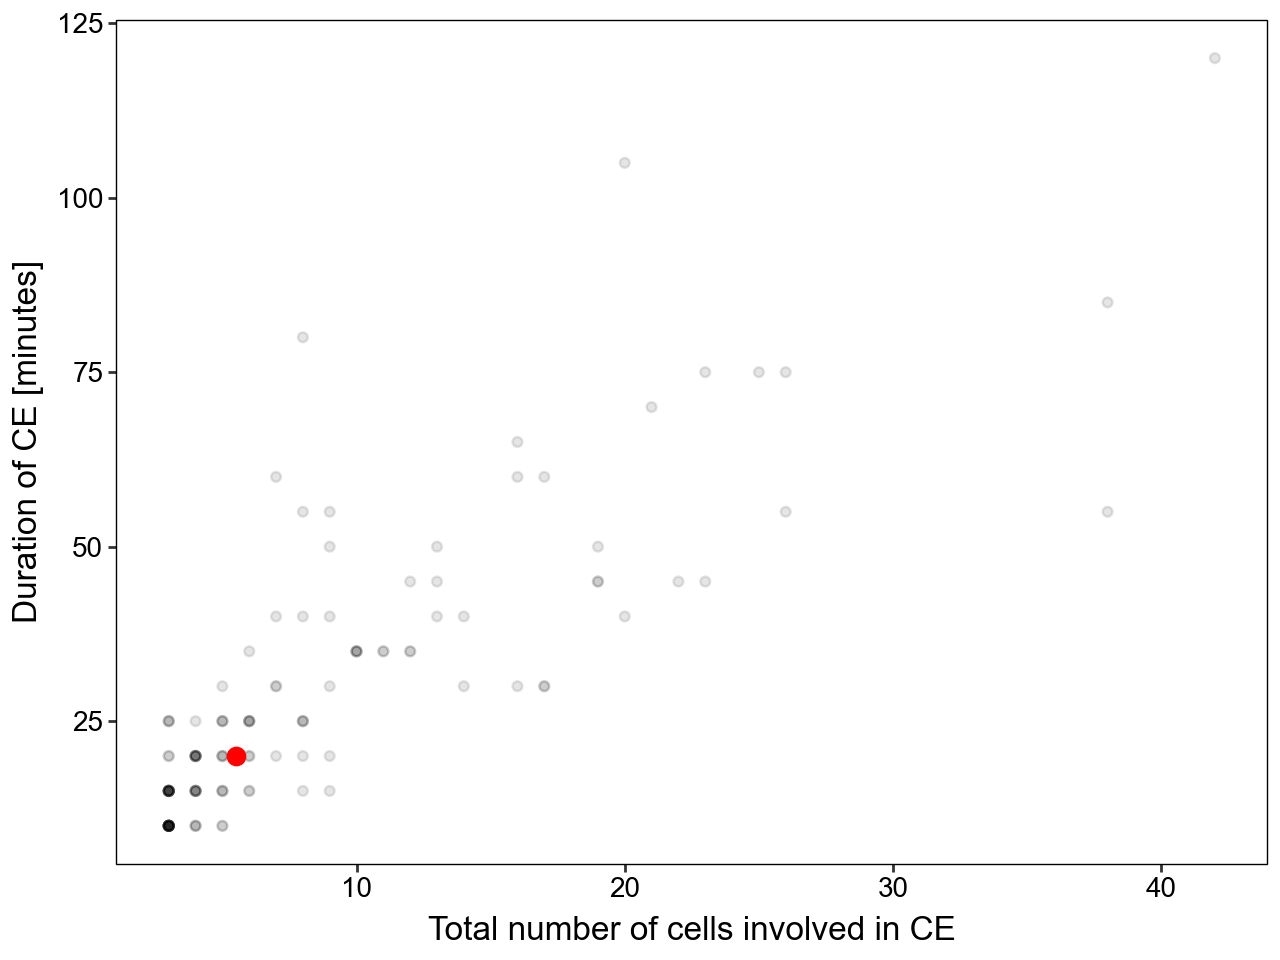

In [49]:
# Plot size vs duration of CEs
p_ce_dur_sz = (
    p9.ggplot(df_ce_stats, p9.aes(x="total_size", y="duration * ACQ_FREQ"))
    # + p9.geom_jitter(alpha=0.1)
    + p9.geom_point(alpha=0.1)
    + p9.geom_point(
        data=pd.DataFrame(
            data={
                "total_size": [median_total_size_CE],
                "duration": [median_duration_CE],
            }
        ),
        color="red",
        size=3,
    )
    + p9.xlab("Total number of cells involved in CE")
    + p9.ylab("Duration of CE [minutes]")
    + p9.theme_bw()
    + p9.theme(
        legend_position="right",
        panel_grid=p9.element_blank(),
        panel_border=p9.element_rect(size=0.5, colour="black"),
        panel_background=p9.element_blank(),
        text=p9.element_text(family="Arial"),
        axis_text_x=p9.element_text(colour="black", size=10),
        axis_text_y=p9.element_text(colour="black", size=10),
        axis_title_x=p9.element_text(colour="black", size=12),
        axis_title_y=p9.element_text(colour="black", size=12),
    )
)

if PLOT_SAVE:
    p9.ggsave(
        p_ce_dur_sz, f"{DIR_OUT_PLOT}/fig6-ce-dur-sz.pdf", width=3.5, height=3, dpi=300
    )

p_ce_dur_sz

## Sample CE

For a single time frame, show a convex hull around a collective event overlaid on the ERK-KTR image.

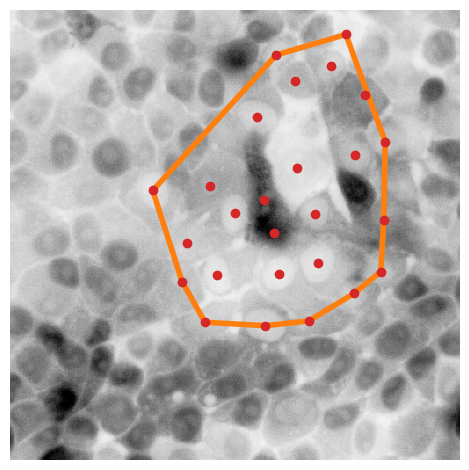

In [50]:
# close the figure window
plt.close()

# Select a single, cropped frame from the ARCOS output
df_ce_show = df_ce[
    (df_ce[COL_FRAME] == n_frame_show)
    & (df_ce[COL_POS[0]].between(fov_crop_x.start, fov_crop_x.stop))
    & (df_ce[COL_POS[1]].between(fov_crop_y.start, fov_crop_y.stop))
]

# Calculate the Convex Hull
m_xy_ce = df_ce_show[[COL_POS[0], COL_POS[1]]].values
chull = ConvexHull(m_xy_ce)

# Overlay the points and chull onto the image
np_erk_show = np_erk[n_frame_show, fov_crop_y, fov_crop_x]
plt.imshow(np_erk_show, cmap="Greys", interpolation="none", vmin=1500, vmax=7000)

for simplex in chull.simplices:
    plt.plot(
        m_xy_ce[simplex, 0] - fov_crop_x.start,
        m_xy_ce[simplex, 1] - fov_crop_y.start,
        "-",
        color="#ff7f0e",
        linewidth=4,
    )
plt.plot(
    m_xy_ce[:, 0] - fov_crop_x.start,
    m_xy_ce[:, 1] - fov_crop_y.start,
    "o",
    color="#d62728",
)

plt.axis("off")
plt.tight_layout()

if PLOT_SAVE:
    plt.savefig(
        f"{DIR_OUT_PLOT}/fig2-ce-erk.png", bbox_inches="tight", pad_inches=0.0, dpi=300
    )
plt.show()

In [51]:
# Prepare a napari layer with CEs
if IMG_NAPARI:
    colors = np.take(
        np.array(TAB20),
        # np.unique(dfCE_filtered[COL_COLL_ID].factorize()[0]),
        [i + 1 for i in np.unique(df_ce_filt[COL_COLL_ID].factorize()[0])],
        mode="wrap",
    )

    df_w_colors = pd.merge(
        df_ce_filt,
        pd.DataFrame(
            data={"colors": colors, COL_COLL_ID: df_ce_filt[COL_COLL_ID].unique()}
        ),
    )
    ce_points = df_w_colors[[COL_FRAME, COL_POS[1], COL_POS[0]]].to_numpy()
    ce_colors = df_w_colors["colors"].to_numpy("str")

    # Show in napari
    viewer.add_points(ce_points, face_color=ce_colors, size=15)

# Exporting movies

Export the current view in napari as an RGB TIFF stack using the `timestamper` plugin ([GitHub](https://github.com/bgraedel/napari-timestamper)).

In [ ]:
from napari_timestamper import render_as_rgb

if DATA_SAVE & IMG_NAPARI:
    # from skimage import io
    _stack = render_as_rgb(viewer, axis=0, upsample_factor=1)
    imwrite(f"{DIR_OUT_DATA}/curr-napari-view.tif", _stack)

# Validation of CE stats

Here, we validate the statistics of collective events by performing a randomization test: shuffle the entire original time series in space between initial spatial positions of existing cells (cf. Fig. S1 B in the [ARCOS paper](https://doi.org/10.1083/jcb.202207048)). This is the recommended method as it only disturbs the spatial component while conserving individual cells’ measurement dynamics and the population-averaged activity over time. By computing the statistics, duration and total size of collective events, from the randomized data, we can calculate the p-value, which is the fraction of cases when the statistic from randomized data was at least as extreme as the observed statistic ([Philip Good, 2005](https://link.springer.com/book/10.1007/b138696)). 

In [ ]:
# randomly shuffle time series
df_resampled = validation.resample_data(
    data=df_tracks_long,
    position_columns=COL_POS,
    frame_column=COL_FRAME,
    obj_id_column=COL_TRK_ID,
    measurement_column=COL_MEAS,
    method="shuffle_tracks",
    n=N_VALID_STEPS,
    seed=42,
    allow_duplicates=False,
    max_tries=100,
    verbose=True,
    show_progress=True,
    parallel_processing=True,
)

In [ ]:
# calculate stats, duration and size of collective events from shuffled time series
df_ce_valid_stats, df_ce_valid_mean = validation.calculate_arcos_stats(
    df_resampled=df_resampled,
    iterations=range(N_VALID_STEPS),
    position_columns=COL_POS,
    frame_column=COL_FRAME,
    obj_id_column=COL_TRK_ID,
    measurement_column=COL_MEAS,
    smooth_k=SMOOTHK,
    bias_k=BIASK,
    peak_threshold=PEAK_THRESHOLD,
    binarization_threshold=BINARIZATION_THRESHOLD,
    bias_method=DETRENDING_METHOD,
    eps=EPS_COLL,
    min_clustersize=MIN_CLUSTER_SIZE,
    n_prev=NPREV_FRAMES,
    min_duration=MIN_COLLECTIVE_EVENT_DURATION,
    min_total_size=MIN_TOTAL_EVENT_SIZE,
    show_progress=True,
    parallel_processing=True,
)

Note: the iteration = 0 contains the observed statistics!!!

/Users/maciekd/miniforge3/envs/stardist_test/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3 x 1.5 in image.
/Users/maciekd/miniforge3/envs/stardist_test/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: output-plots/fig4-ce-valid-size.pdf


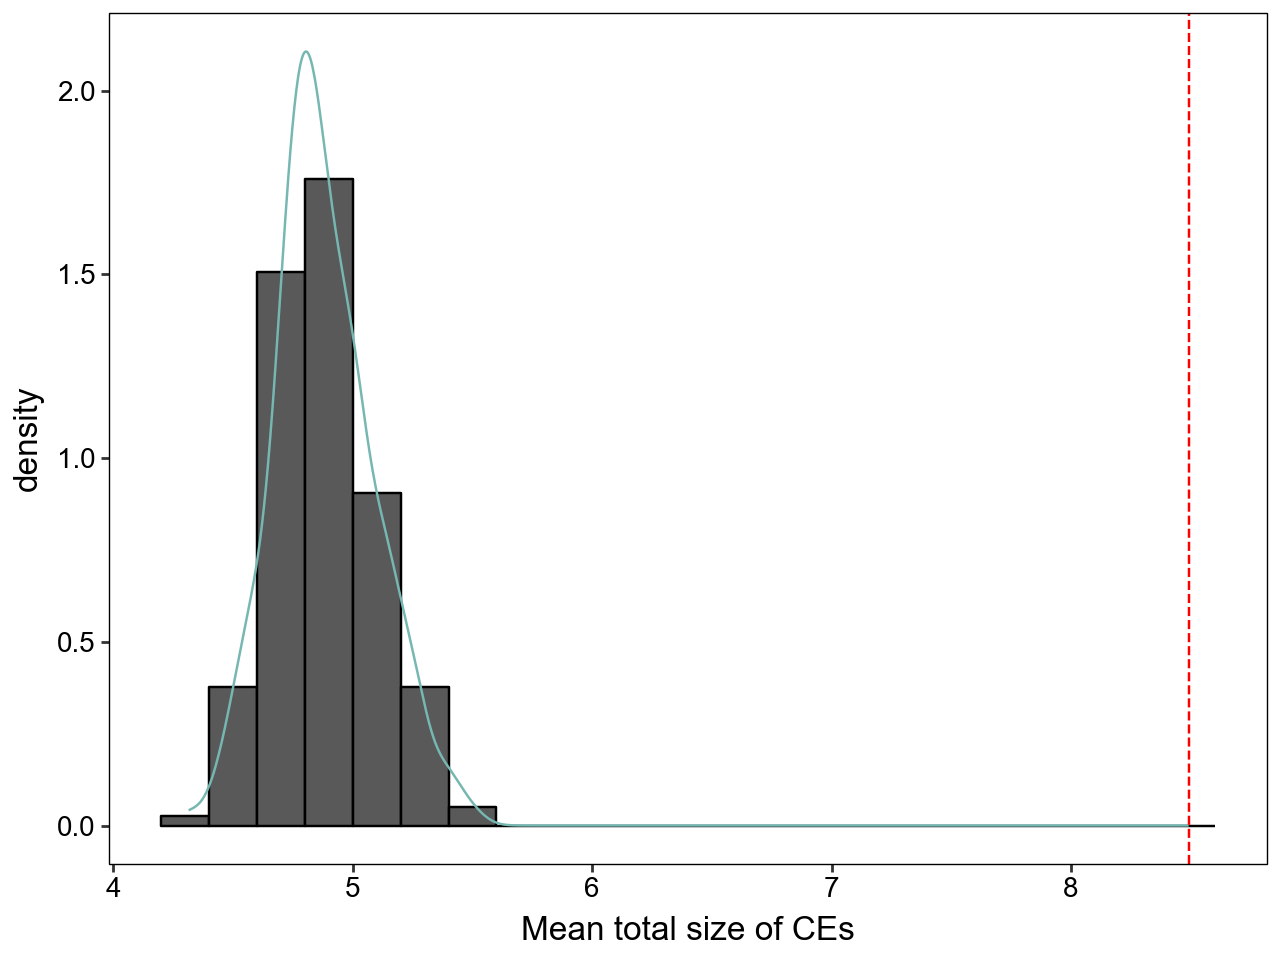

In [50]:
p_ce_valid_size = (
    p9.ggplot(
        df_ce_valid_mean[df_ce_valid_mean["bootstrap_iteration"] > 0],
        p9.aes(x="total_size", y=p9.after_stat("density")),
    )
    + p9.geom_histogram(binwidth=0.2, boundary=0, color="black")
    + p9.geom_density(color="#76B7B2")
    + p9.geom_vline(xintercept=mean_total_size_CE, color="red", linetype="dashed")
    + p9.xlab("Mean total size of CEs")
    + p9.ylab("density")
    + p9.theme_bw()
    + p9.theme(
        legend_position="none",
        panel_grid=p9.element_blank(),
        panel_border=p9.element_rect(size=0.5, colour="black"),
        panel_background=p9.element_blank(),
        text=p9.element_text(family="Arial"),
        axis_text_x=p9.element_text(colour="black", size=10),
        axis_text_y=p9.element_text(colour="black", size=10),
        axis_title_x=p9.element_text(colour="black", size=12),
        axis_title_y=p9.element_text(colour="black", size=12),
    )
)

if PLOT_SAVE:
    p9.ggsave(
        p_ce_valid_size, f"{DIR_OUT_PLOT}/fig6-ce-valid-size.pdf", width=3, height=1.5
    )

p_ce_valid_size

The p-value for the one-sided, unpaired randomization test for the mean total size of CEs. 
Alternative hypothesis: the mean total size of CEs detected by ARCOS is greater that the total size obtained in a randomized system without space–time correlations.

In [51]:
(
    1
    + np.sum(
        df_ce_valid_mean[df_ce_valid_mean["bootstrap_iteration"] > 0]["total_size"]
        >= mean_total_size_CE
    )
) / (1 + N_VALID_STEPS)

0.004975124378109453

/Users/maciekd/miniforge3/envs/stardist_test/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3 x 1.5 in image.
/Users/maciekd/miniforge3/envs/stardist_test/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: output-plots/fig4-ce-valid-dur.pdf


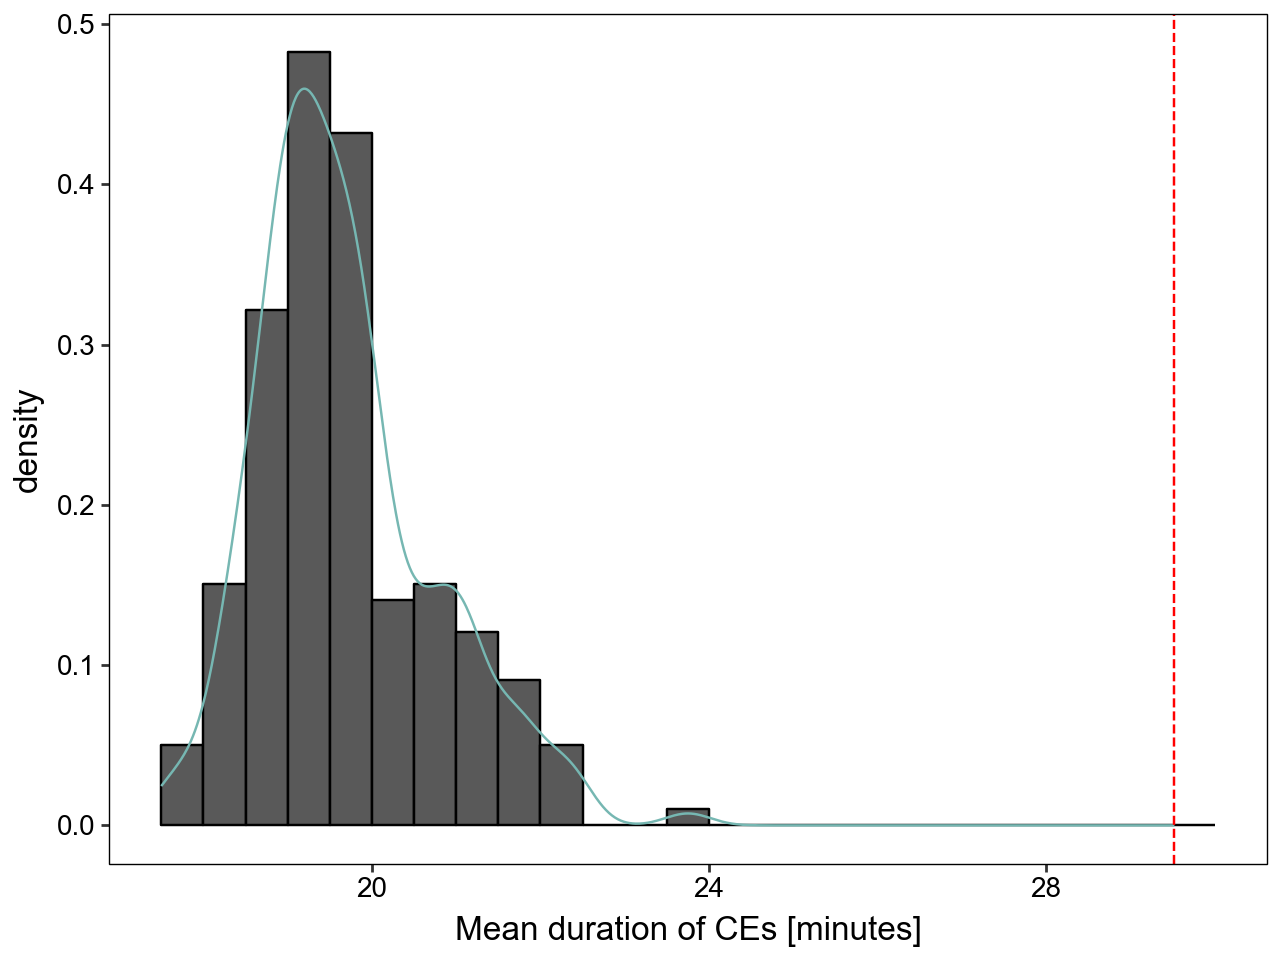

In [52]:
p_ce_valid_dur = (
    p9.ggplot(
        df_ce_valid_mean[df_ce_valid_mean["bootstrap_iteration"] > 0],
        p9.aes(x="duration * ACQ_FREQ", y=p9.after_stat("density")),
    )
    + p9.geom_histogram(binwidth=0.5, boundary=0, color="black")
    + p9.geom_density(color="#76B7B2")
    + p9.geom_vline(
        xintercept=mean_duration_CE * ACQ_FREQ, color="red", linetype="dashed"
    )
    + p9.xlab("Mean duration of CEs [minutes]")
    + p9.ylab("density")
    + p9.theme_bw()
    + p9.theme(
        legend_position="none",
        panel_grid=p9.element_blank(),
        panel_border=p9.element_rect(size=0.5, colour="black"),
        panel_background=p9.element_blank(),
        text=p9.element_text(family="Arial"),
        axis_text_x=p9.element_text(colour="black", size=10),
        axis_text_y=p9.element_text(colour="black", size=10),
        axis_title_x=p9.element_text(colour="black", size=12),
        axis_title_y=p9.element_text(colour="black", size=12),
    )
)

if PLOT_SAVE:
    p9.ggsave(p_ce_valid_dur, f"{DIR_OUT_PLOT}/fig6-ce-valid-dur.pdf", width=3, height=1.5)

p_ce_valid_dur

The p-value for the one-sided, unpaired randomization test for the mean duration of CEs. 
Alternative hypothesis: the mean duration of CEs detected by ARCOS is greater than the mean duration obtained in a randomized system without space–time correlations.

In [53]:
(
    1
    + np.sum(
        df_ce_valid_mean[df_ce_valid_mean["bootstrap_iteration"] > 0]["duration"]
        >= mean_duration_CE
    )
) / (1 + N_VALID_STEPS)

0.004975124378109453